# Dense Training Following Preconditioning

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
from tqdm.auto import tqdm, trange

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# Data Preparation Functions

In [ ]:
import numpy as np
import torch 
from torch.utils.data import Dataset

def print_params(P,general=True,ncvx=False,cvx=False):
    pl = []
    for k,v in P.items():
        start = k.split('_')[0]
        if (start == 'cvx' and cvx) or (start == 'ncvx' and ncvx) or \
           (start != 'cvx' and start != 'ncvx' and general):
           pl.append((k,v))
    param_len = len(max(pl,key=lambda x: len(x[0]))[0]) + 1
    print("{1:<{0}}: Value\n{2:}".format(param_len,"Parameter","="*(param_len+7)))
    print("\n".join(["{1:<{0}}: {2:}".format(param_len,k,v) for k,v in pl]))

def check_if_already_exists(element_list, element):
    # check if element exists in element_list where element is a numpy array
    for i in range(len(element_list)):
        if np.array_equal(element_list[i], element):
            return True
    return False

class PrepareData3D(Dataset):
    def __init__(self, X, y, z):
        self.X = torch.from_numpy(X) if not torch.is_tensor(X) else X
        self.y = torch.from_numpy(y) if not torch.is_tensor(y) else y
        self.z = torch.from_numpy(z) if not torch.is_tensor(z) else z

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.z[idx]

def one_hot(labels, num_classes=10):
    y = torch.eye(num_classes) 
    return y[labels.long()] 

In [ ]:
def save_params(P,path):
    with open(path,'w') as f:
        f.write(json.dumps(P))

def load_params(path):
    with open(path,'r') as f:
        data = f.read()
    return json.loads(data)

# Parameters and Args

# Load Data
Downloads CIFAR10 if not already downloaded.  

In [ ]:
dataset = 'CIFAR10'
normalize = transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])

train_dataset = datasets.CIFAR10(P['dir'], train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor(), normalize]),
    target_transform=lambda x: float(x >= 5))

test_dataset = datasets.CIFAR10(P['dir'], train=False, download=True,
    transform=transforms.Compose([transforms.ToTensor(), normalize,]),
    target_transform=lambda x: float(x >= 5))

# Extract the data via a dummy loader (dumps entire dataset at once)
dummy_loader= torch.utils.data.DataLoader(train_dataset, batch_size=50000, shuffle=False, pin_memory=True, sampler=None)
for A, y in dummy_loader:
    pass
Apatch=A.detach().clone() # Detaches from graph

A = A.view(A.shape[0], -1)
n,dim_in=A.size()

print("Apatch (Detached A) Shape:",Apatch.shape)
print("A shape:", A.shape)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified
Apatch (Detached A) Shape: torch.Size([50000, 3, 32, 32])
A shape: torch.Size([50000, 3072])


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=False, pin_memory=True, sampler=None)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False, pin_memory=True, sampler=None)

# Models
## Standard Non-Convex Network
Consists of typical 2-layer network definition, training and test loss, as well as training loop. 

In [ ]:
num_neurons = 1000

class FCNetwork(nn.Module):
  def __init__(self, layers, num_classes=1, input_dim=3072):
      self.num_classes = num_classes
      self.input_dim = input_dim
      super(FCNetwork, self).__init__()

      if isinstance(layers, int):
        all_layers = []
        for layer in range(layers - 1):
          if layer == 0:
            data = np.random.uniform(-1, 1, (input_dim, num_neurons))
            data = data * np.sqrt(6 / input_dim)
            all_layers.append(data)
          else:
            data = np.random.uniform(-1, 1, (num_neurons, num_neurons))
            data = data * np.sqrt(6 / num_neurons)
            all_layers.append(data)
          
        data = np.random.uniform(-1, 1, (num_neurons, 1))
        data = data * np.sqrt(6 / num_neurons)
        all_layers.append(data)
      else:
        all_layers = [l.T for l in layers]

      self.layers = map(torch.FloatTensor, all_layers)
      self.layers = list(map(torch.nn.Parameter, self.layers))
      self.layers = nn.ParameterList(self.layers)

      print([x.shape for x in self.layers])
      
  def forward(self, x):
      x = x.reshape(x.size(0), -1)
      for layer in self.layers:
        x = nn.ReLU()(x @ layer)
      return x

In [ ]:
info = {}

In [ ]:
import json

models = {}
for data in [100]:
  filename = f"model_{data}.json"
  key = data
  if data > 0:
    with open(filename) as fp:
      data = json.load(fp)
    data = [np.array(d) for d in data]
    model = FCNetwork(data)
  else:
    model = FCNetwork(4)
  info[key] = sgd_solver_pytorch(model)
  break

[torch.Size([3072, 1000]), torch.Size([1000, 1000]), torch.Size([1000, 1000]), torch.Size([1000, 1])]
Preparing model. Please wait.
Preparing optimizer.
[torch.Size([3072, 1000]), torch.Size([1000, 1000]), torch.Size([1000, 1000]), torch.Size([1000, 1])]
Preparing schedule.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/100], loss: 0.123 acc: 0.603, test loss: 0.122 test acc: 0.593


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/100], loss: 0.118 acc: 0.598, test loss: 0.118 test acc: 0.613


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/100], loss: 0.115 acc: 0.610, test loss: 0.115 test acc: 0.624


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/100], loss: 0.113 acc: 0.631, test loss: 0.114 test acc: 0.632


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/100], loss: 0.112 acc: 0.639, test loss: 0.113 test acc: 0.637


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.110 acc: 0.648, test loss: 0.112 test acc: 0.641


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.109 acc: 0.654, test loss: 0.111 test acc: 0.644


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.108 acc: 0.660, test loss: 0.110 test acc: 0.645


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.107 acc: 0.662, test loss: 0.110 test acc: 0.648


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.106 acc: 0.670, test loss: 0.109 test acc: 0.651


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.105 acc: 0.675, test loss: 0.109 test acc: 0.651


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.104 acc: 0.684, test loss: 0.108 test acc: 0.653


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.103 acc: 0.688, test loss: 0.108 test acc: 0.655


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.102 acc: 0.689, test loss: 0.107 test acc: 0.658


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.101 acc: 0.693, test loss: 0.107 test acc: 0.660


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.100 acc: 0.694, test loss: 0.107 test acc: 0.661


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.099 acc: 0.694, test loss: 0.106 test acc: 0.663


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.098 acc: 0.692, test loss: 0.106 test acc: 0.665


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.098 acc: 0.698, test loss: 0.106 test acc: 0.666


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.097 acc: 0.696, test loss: 0.105 test acc: 0.668


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.096 acc: 0.702, test loss: 0.105 test acc: 0.672


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.095 acc: 0.712, test loss: 0.105 test acc: 0.672


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.094 acc: 0.716, test loss: 0.105 test acc: 0.673


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.093 acc: 0.720, test loss: 0.104 test acc: 0.675


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.092 acc: 0.726, test loss: 0.104 test acc: 0.675


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.091 acc: 0.727, test loss: 0.104 test acc: 0.675


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.090 acc: 0.732, test loss: 0.104 test acc: 0.676


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.089 acc: 0.734, test loss: 0.104 test acc: 0.678


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.088 acc: 0.738, test loss: 0.104 test acc: 0.678


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.086 acc: 0.744, test loss: 0.104 test acc: 0.679


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.085 acc: 0.748, test loss: 0.104 test acc: 0.677


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.085 acc: 0.752, test loss: 0.104 test acc: 0.677


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.084 acc: 0.754, test loss: 0.104 test acc: 0.678


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.083 acc: 0.760, test loss: 0.104 test acc: 0.677


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.082 acc: 0.762, test loss: 0.104 test acc: 0.677


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.081 acc: 0.767, test loss: 0.104 test acc: 0.679


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.080 acc: 0.769, test loss: 0.104 test acc: 0.680


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.080 acc: 0.769, test loss: 0.103 test acc: 0.681


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.079 acc: 0.774, test loss: 0.103 test acc: 0.682


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.077 acc: 0.772, test loss: 0.103 test acc: 0.683


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.076 acc: 0.784, test loss: 0.103 test acc: 0.683


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.075 acc: 0.793, test loss: 0.104 test acc: 0.685


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.074 acc: 0.800, test loss: 0.104 test acc: 0.685


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.073 acc: 0.801, test loss: 0.104 test acc: 0.686


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.072 acc: 0.804, test loss: 0.104 test acc: 0.684


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.071 acc: 0.806, test loss: 0.104 test acc: 0.684


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.070 acc: 0.807, test loss: 0.104 test acc: 0.684


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.069 acc: 0.808, test loss: 0.104 test acc: 0.685


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.068 acc: 0.814, test loss: 0.104 test acc: 0.686


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.067 acc: 0.816, test loss: 0.104 test acc: 0.686


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.066 acc: 0.827, test loss: 0.104 test acc: 0.686


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.065 acc: 0.836, test loss: 0.104 test acc: 0.684


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.064 acc: 0.840, test loss: 0.105 test acc: 0.684


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.063 acc: 0.845, test loss: 0.105 test acc: 0.684


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.062 acc: 0.848, test loss: 0.105 test acc: 0.684


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.061 acc: 0.848, test loss: 0.106 test acc: 0.687


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.060 acc: 0.838, test loss: 0.107 test acc: 0.685


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.060 acc: 0.846, test loss: 0.107 test acc: 0.687


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.058 acc: 0.854, test loss: 0.107 test acc: 0.686


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.057 acc: 0.860, test loss: 0.107 test acc: 0.687


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.057 acc: 0.856, test loss: 0.107 test acc: 0.686


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.056 acc: 0.852, test loss: 0.108 test acc: 0.687


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.055 acc: 0.857, test loss: 0.109 test acc: 0.686


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.053 acc: 0.866, test loss: 0.110 test acc: 0.684


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.051 acc: 0.879, test loss: 0.111 test acc: 0.683


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.050 acc: 0.880, test loss: 0.112 test acc: 0.684


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.049 acc: 0.878, test loss: 0.113 test acc: 0.686


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.049 acc: 0.880, test loss: 0.115 test acc: 0.683


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.049 acc: 0.880, test loss: 0.119 test acc: 0.675


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.086 acc: 0.778, test loss: 0.112 test acc: 0.680


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.068 acc: 0.817, test loss: 0.114 test acc: 0.681


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.055 acc: 0.860, test loss: 0.111 test acc: 0.686


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.047 acc: 0.899, test loss: 0.113 test acc: 0.685


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.043 acc: 0.915, test loss: 0.111 test acc: 0.684


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.044 acc: 0.904, test loss: 0.115 test acc: 0.681


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.041 acc: 0.908, test loss: 0.123 test acc: 0.672


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.048 acc: 0.890, test loss: 0.133 test acc: 0.666


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.042 acc: 0.909, test loss: 0.119 test acc: 0.683


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.045 acc: 0.892, test loss: 0.120 test acc: 0.674


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.050 acc: 0.875, test loss: 0.123 test acc: 0.664


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.048 acc: 0.887, test loss: 0.126 test acc: 0.672


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.040 acc: 0.916, test loss: 0.119 test acc: 0.682


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.038 acc: 0.932, test loss: 0.115 test acc: 0.680


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.053 acc: 0.867, test loss: 0.125 test acc: 0.664


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.042 acc: 0.910, test loss: 0.119 test acc: 0.679


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.034 acc: 0.947, test loss: 0.140 test acc: 0.655


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.049 acc: 0.887, test loss: 0.138 test acc: 0.659


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.062 acc: 0.830, test loss: 0.124 test acc: 0.667


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.032 acc: 0.944, test loss: 0.127 test acc: 0.676


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.033 acc: 0.940, test loss: 0.117 test acc: 0.689


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.029 acc: 0.951, test loss: 0.119 test acc: 0.685


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.053 acc: 0.867, test loss: 0.122 test acc: 0.673


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.032 acc: 0.935, test loss: 0.161 test acc: 0.637


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.062 acc: 0.840, test loss: 0.122 test acc: 0.677


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.037 acc: 0.929, test loss: 0.133 test acc: 0.675


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.029 acc: 0.954, test loss: 0.136 test acc: 0.668


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.026 acc: 0.962, test loss: 0.121 test acc: 0.684


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.029 acc: 0.954, test loss: 0.129 test acc: 0.679


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.069 acc: 0.824, test loss: 0.144 test acc: 0.657


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.060 acc: 0.838, test loss: 0.119 test acc: 0.669


In [ ]:
import json

models = {}
for data in [1000]:
  filename = f"model_{data}.json"
  key = data
  if data > 0:
    with open(filename) as fp:
      data = json.load(fp)
    data = [np.array(d) for d in data]
    model = FCNetwork(data)
  else:
    model = FCNetwork(4)
  info[key] = sgd_solver_pytorch(model)
  break

[torch.Size([3072, 1000]), torch.Size([1000, 1000]), torch.Size([1000, 1000]), torch.Size([1000, 1])]
Preparing model. Please wait.
Preparing optimizer.
[torch.Size([3072, 1000]), torch.Size([1000, 1000]), torch.Size([1000, 1000]), torch.Size([1000, 1])]
Preparing schedule.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/100], loss: 0.115 acc: 0.619, test loss: 0.117 test acc: 0.616


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/100], loss: 0.111 acc: 0.636, test loss: 0.113 test acc: 0.632


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/100], loss: 0.108 acc: 0.650, test loss: 0.111 test acc: 0.641


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/100], loss: 0.107 acc: 0.654, test loss: 0.110 test acc: 0.649


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/100], loss: 0.105 acc: 0.667, test loss: 0.109 test acc: 0.655


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.103 acc: 0.673, test loss: 0.108 test acc: 0.659


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.102 acc: 0.687, test loss: 0.107 test acc: 0.662


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.100 acc: 0.695, test loss: 0.106 test acc: 0.667


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.097 acc: 0.713, test loss: 0.106 test acc: 0.671


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.095 acc: 0.726, test loss: 0.105 test acc: 0.674


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.093 acc: 0.720, test loss: 0.105 test acc: 0.673


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.091 acc: 0.730, test loss: 0.104 test acc: 0.675


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.088 acc: 0.740, test loss: 0.104 test acc: 0.680


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.085 acc: 0.749, test loss: 0.105 test acc: 0.682


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.083 acc: 0.759, test loss: 0.106 test acc: 0.682


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.081 acc: 0.773, test loss: 0.105 test acc: 0.684


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.078 acc: 0.782, test loss: 0.103 test acc: 0.684


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.076 acc: 0.781, test loss: 0.103 test acc: 0.685


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.074 acc: 0.788, test loss: 0.104 test acc: 0.685


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.072 acc: 0.800, test loss: 0.105 test acc: 0.686


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.070 acc: 0.806, test loss: 0.108 test acc: 0.682


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.068 acc: 0.813, test loss: 0.108 test acc: 0.690


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.067 acc: 0.819, test loss: 0.108 test acc: 0.686


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.073 acc: 0.794, test loss: 0.109 test acc: 0.681


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.066 acc: 0.819, test loss: 0.113 test acc: 0.677


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.070 acc: 0.822, test loss: 0.110 test acc: 0.673


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.065 acc: 0.823, test loss: 0.108 test acc: 0.682


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.060 acc: 0.850, test loss: 0.108 test acc: 0.691


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.064 acc: 0.829, test loss: 0.115 test acc: 0.684


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.063 acc: 0.843, test loss: 0.112 test acc: 0.675


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.055 acc: 0.862, test loss: 0.115 test acc: 0.685


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.069 acc: 0.808, test loss: 0.114 test acc: 0.677


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.056 acc: 0.865, test loss: 0.112 test acc: 0.678


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.060 acc: 0.840, test loss: 0.109 test acc: 0.689


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.054 acc: 0.869, test loss: 0.110 test acc: 0.685


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.051 acc: 0.884, test loss: 0.114 test acc: 0.678


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.046 acc: 0.898, test loss: 0.112 test acc: 0.689


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.045 acc: 0.900, test loss: 0.115 test acc: 0.689


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.095 acc: 0.702, test loss: 0.106 test acc: 0.662


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.085 acc: 0.747, test loss: 0.102 test acc: 0.682


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.075 acc: 0.785, test loss: 0.102 test acc: 0.688


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.069 acc: 0.815, test loss: 0.102 test acc: 0.693


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.065 acc: 0.835, test loss: 0.103 test acc: 0.696


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.062 acc: 0.848, test loss: 0.103 test acc: 0.696


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.059 acc: 0.857, test loss: 0.103 test acc: 0.697


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.055 acc: 0.878, test loss: 0.103 test acc: 0.698


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.051 acc: 0.888, test loss: 0.104 test acc: 0.698


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.048 acc: 0.899, test loss: 0.105 test acc: 0.695


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.046 acc: 0.904, test loss: 0.106 test acc: 0.693


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.044 acc: 0.913, test loss: 0.107 test acc: 0.696


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.045 acc: 0.906, test loss: 0.110 test acc: 0.690


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.046 acc: 0.902, test loss: 0.115 test acc: 0.681


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.042 acc: 0.922, test loss: 0.109 test acc: 0.700


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.038 acc: 0.929, test loss: 0.110 test acc: 0.698


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.049 acc: 0.890, test loss: 0.117 test acc: 0.688


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.038 acc: 0.932, test loss: 0.113 test acc: 0.691


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.033 acc: 0.950, test loss: 0.113 test acc: 0.695


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.036 acc: 0.931, test loss: 0.113 test acc: 0.697


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.030 acc: 0.951, test loss: 0.114 test acc: 0.695


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.043 acc: 0.906, test loss: 0.124 test acc: 0.678


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.042 acc: 0.917, test loss: 0.126 test acc: 0.659


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.037 acc: 0.935, test loss: 0.120 test acc: 0.672


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.030 acc: 0.959, test loss: 0.118 test acc: 0.675


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.030 acc: 0.954, test loss: 0.118 test acc: 0.680


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.033 acc: 0.942, test loss: 0.120 test acc: 0.677


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.046 acc: 0.905, test loss: 0.129 test acc: 0.675


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.041 acc: 0.927, test loss: 0.121 test acc: 0.679


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.040 acc: 0.915, test loss: 0.126 test acc: 0.675


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.039 acc: 0.908, test loss: 0.126 test acc: 0.676


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.036 acc: 0.923, test loss: 0.124 test acc: 0.682


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.028 acc: 0.960, test loss: 0.121 test acc: 0.683


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.026 acc: 0.962, test loss: 0.117 test acc: 0.689


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.024 acc: 0.965, test loss: 0.118 test acc: 0.687


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.022 acc: 0.968, test loss: 0.118 test acc: 0.691


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.021 acc: 0.972, test loss: 0.119 test acc: 0.689


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.020 acc: 0.973, test loss: 0.120 test acc: 0.687


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.019 acc: 0.981, test loss: 0.122 test acc: 0.687


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.020 acc: 0.974, test loss: 0.124 test acc: 0.678


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.029 acc: 0.963, test loss: 0.120 test acc: 0.679


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.022 acc: 0.980, test loss: 0.122 test acc: 0.683


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.045 acc: 0.908, test loss: 0.152 test acc: 0.641


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.037 acc: 0.917, test loss: 0.126 test acc: 0.676


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.051 acc: 0.887, test loss: 0.148 test acc: 0.667


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.060 acc: 0.848, test loss: 0.116 test acc: 0.685


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.038 acc: 0.920, test loss: 0.127 test acc: 0.680


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.040 acc: 0.907, test loss: 0.123 test acc: 0.681


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.050 acc: 0.883, test loss: 0.119 test acc: 0.685


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.044 acc: 0.903, test loss: 0.117 test acc: 0.683


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.038 acc: 0.921, test loss: 0.116 test acc: 0.688


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.024 acc: 0.965, test loss: 0.121 test acc: 0.689


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.023 acc: 0.968, test loss: 0.119 test acc: 0.691


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.021 acc: 0.969, test loss: 0.123 test acc: 0.688


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.020 acc: 0.971, test loss: 0.124 test acc: 0.685


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.022 acc: 0.967, test loss: 0.123 test acc: 0.685


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.025 acc: 0.964, test loss: 0.129 test acc: 0.671


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.037 acc: 0.927, test loss: 0.117 test acc: 0.688


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.047 acc: 0.901, test loss: 0.125 test acc: 0.668


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.037 acc: 0.930, test loss: 0.124 test acc: 0.680


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.035 acc: 0.939, test loss: 0.126 test acc: 0.676


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.032 acc: 0.947, test loss: 0.125 test acc: 0.680


In [ ]:
import seaborn as sns
sns.set_style('darkgrid')

import matplotlib
font = {'size'   : 16}

matplotlib.rc('font', **font)


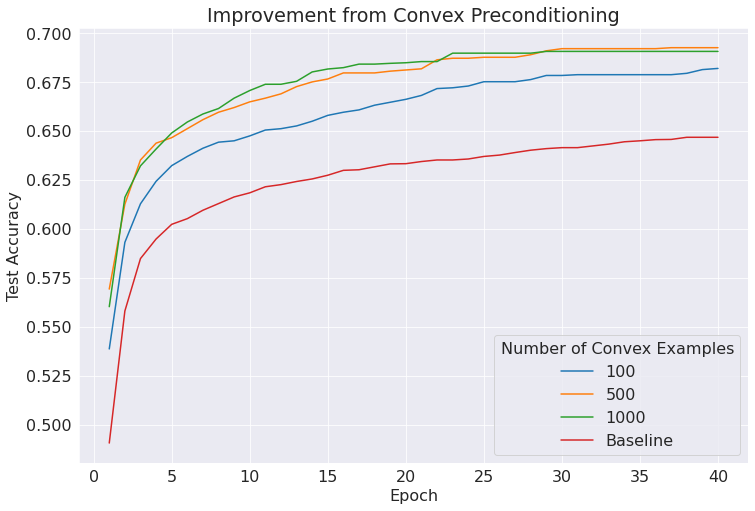

In [ ]:
plt.figure(figsize=(12, 8))
for k in [100, 500, 1000]:
  test_acc = np.maximum.accumulate(info[k][-3])
  plt.plot(range(1, 41), test_acc[:40], label=f"{k}")

plt.plot(range(1, 41), np.maximum.accumulate(info[0][-3])[:40], label=f"Baseline")
plt.legend(title="Number of Convex Examples", loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Improvement from Convex Preconditioning')
plt.show()

In [ ]:
def loss_func_primal(yhat, y, model, beta):
    loss = 0.5 * torch.norm(yhat - y)**2
    # l2 norm on first layer weights, l1 squared norm on second layer
    for layer, p in enumerate(model.parameters()):
        if layer != 3:
            loss += beta/2 * torch.norm(p)**2
        else:
            loss += beta/2 * sum([torch.norm(p[:, j], p=2)**2 for j in range(p.shape[1])])
    return loss

def validation_primal(model, testloader, beta, device):
    test_loss = 0
    test_correct = 0
    for ix, (_x, _y) in enumerate(testloader):
        _x = Variable(_x).float().to(device)
        _y = Variable(_y).float().to(device)
        #output = model.forward(_x) # Does this do anything?
        yhat = model(_x).float().squeeze()
        loss = loss_func_primal(yhat, _y.to(device), model, beta)
        test_loss += loss.item()
        equal = torch.eq((yhat > 0.5).float(), _y.squeeze()).float()
        test_correct += equal.sum()
    return test_loss, test_correct


def sgd_solver_pytorch(model, num_epochs=100, beta=1e-3,
                       learning_rate=1e-3, batch_size=1000, solver_type='sgd', schedule=0, 
                       LBFGS_param=(10,4), verbose=False, num_classes=1, dim_in=3*1024, 
                       test_len=10000, train_len=50000, device='cuda'):
    """
    ds            : Training dataset (torch DataLoader)
    ds_test       : Test dataset (torch DataLoader)
    save_path     : str, path to save the model at (doesn't save if '')
    num_epochs    : int
    num_neurons   : hidden layer size, int
    beta          : regularization scalar on the norms of the weight matrices, float
    learning rate : float
    batch_size    : int
    solver_type   : any in ['sgd','adam','adagrad','adadelta','LBFGS']
    schedule      : int in (0: Nothing, 1: ReduceLROnPlateau, 2: ExponentialLR)
    LBFGS_param   : (int,int) history size and max iterations for solver_type='LBFGS'
    verbose       : bool
    num_classes   : int
    dim_in        : int, input dimension (32*32*3) for cifar10
    test_len      : int, number of test images
    train_len     : int, number of training images
    device        : str, 'cuda' or 'cpu' 
    """

    print("Preparing model. Please wait.", flush=True)
    device = torch.device(device)
    model = model.to(device)
    
    print("Preparing optimizer.")
    print([x.shape for x in list(model.parameters())])
    if solver_type == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif solver_type == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif solver_type == "adagrad":
        optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
    elif solver_type == "adadelta":
        optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
    elif solver_type == "LBFGS":
        optimizer = torch.optim.LBFGS(model.parameters(), history_size=LBFGS_param[0], max_iter=LBFGS_param[1])
        
    # Arrays for saving the loss and accuracy    
    losses = np.zeros((int(num_epochs*np.ceil(train_len / batch_size))))
    accs = np.zeros(losses.shape)
    losses_test = np.zeros((num_epochs+1))
    accs_test = np.zeros((num_epochs+1))
    times = np.zeros((losses.shape[0]+1))
    times[0] = time.time()
    
    # loss on the entire test set
    losses_test[0], accs_test[0] = validation_primal(model, test_loader, beta, device) 
    
    print("Preparing schedule.")
    if schedule==1:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=verbose, factor=0.5, eps=1e-12)
    elif schedule==2:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99)
    elif schedule==3:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs * train_len // batch_size)
        
    iter_no = 0
    start_time = time.time()

    for i in tqdm(range(num_epochs)):
        for ix, (_x, _y) in tqdm(enumerate(train_loader), leave=False, total=train_len // batch_size):
            #=========make input differentiable=======================
            _x = Variable(_x).to(device) # shape 1000,3,32,32
            _y = Variable(_y).to(device) # shape 1000
            #========forward pass=====================================
            yhat = model(_x).float().squeeze()
            
            loss = loss_func_primal(yhat, _y.to(device), model, beta)/len(_y)

            equal = torch.eq((yhat > 0.5).float(), torch.squeeze(_y)).float()
            correct = equal.sum()/len(_y)

            optimizer.zero_grad() # zero the gradients on each pass before the update
            loss.backward()       # backpropagate the loss through the model
            optimizer.step()      # update the gradients w.r.t the loss

            losses[iter_no] = loss.item() # loss on the minibatch
            accs[iter_no] = correct
            iter_no += 1
            times[iter_no] = time.time()
        
        losses_test[i+1], accs_test[i+1] = validation_primal(model, test_loader, beta, device)

        if i % 1 == 0:
            print("Epoch [{:2>}/{:}], loss: {:.3f} acc: {:.3f}, test loss: {:.3f} test acc: {:.3f}".format(i, num_epochs,
                   losses[iter_no-1],accs[iter_no-1],losses_test[i+1]/test_len,accs_test[i+1]/test_len))
        if schedule>0:
            scheduler.step(losses[iter_no-1])

    return losses, accs, losses_test/test_len, accs_test/test_len, times, model

## Convex Network
Haven't cleaned these up as much given that I'm not 100% sure how it works.
TODO: Figure out the hyperplane arangement stuff

In [ ]:
# def generate_conv_sign_patterns(A2, P, verbose=False): 
#     # generate convolutional sign patterns
#     n, c, p1, p2 = A2.shape
#     A = A2.reshape(n,int(c*p1*p2))
#     fsize=9*c
#     d=c*p1*p2;
#     fs=int(np.sqrt(9))
#     unique_sign_pattern_list = []  
#     u_vector_list = []             

#     for i in range(P): 
#         # obtain a sign pattern
#         ind1=np.random.randint(0,p1-fs+1)
#         ind2=np.random.randint(0,p2-fs+1)
#         u1p= np.zeros((c,p1,p2))
#         u1p[:,ind1:ind1+fs,ind2:ind2+fs]=np.random.normal(0, 1, (fsize,1)).reshape(c,fs,fs)
#         u1=u1p.reshape(d,1)
#         sampled_sign_pattern = (np.matmul(A, u1) >= 0)[:,0]
#         unique_sign_pattern_list.append(sampled_sign_pattern)
#         u_vector_list.append(u1)

#     if verbose:
#         print("Number of unique sign patterns generated: " + str(len(unique_sign_pattern_list)))
#     return len(unique_sign_pattern_list),unique_sign_pattern_list, u_vector_list

def generate_sign_patterns(A, P, verbose=False):
    # generate sign patterns
    n, d = A.shape
    sign_pattern_list = []  # sign patterns
    u_vector_list = []             # random vectors used to generate the sign paterns
    umat = np.random.normal(0, 1, (d,P))
    sampled_sign_pattern_mat = (np.matmul(A, umat) >= 0)
    for i in range(P):
        sampled_sign_pattern = sampled_sign_pattern_mat[:,i]
        sign_pattern_list.append(sampled_sign_pattern)
        u_vector_list.append(umat[:,i])
    if verbose:
        print("Number of sign patterns generated: " + str(len(sign_pattern_list)))
    return len(sign_pattern_list),sign_pattern_list, u_vector_list

In [ ]:
class custom_cvx_layer(torch.nn.Module):
    def __init__(self, num_neurons=4096, num_classes=1, input_dim=3072):
        self.num_classes = num_classes
        super(custom_cvx_layer, self).__init__()
        
        # (num_neurons) P x (input_dim) d x (num_classes) C
        self.v = torch.nn.Parameter(data=torch.zeros(num_neurons, input_dim, num_classes), requires_grad=True)
        self.w = torch.nn.Parameter(data=torch.zeros(num_neurons, input_dim, num_classes), requires_grad=True)

    def forward(self, x, sign_patterns):
        print("HI")
        sign_patterns = sign_patterns.unsqueeze(2)
        x = x.view(x.shape[0], -1) # n x d
        
        print('x', x.shape)
        print('sign', sign_patterns.shape)

        Xv_w = torch.matmul(x, self.v - self.w) # P x N x C
        
        print('u,v', self.v.shape, self.w.shape)
        print('Xv_w', Xv_w.shape)

        # for some reason, the permutation is necessary. not sure why
        DXv_w = torch.mul(sign_patterns, Xv_w.permute(1, 0, 2)) #  N x P x C
        y_pred = torch.sum(DXv_w, dim=1, keepdim=False) # N x C
        
        return y_pred
    
def get_nonconvex_cost(y, model, _x, beta, device):
    _x = _x.view(_x.shape[0], -1)
    Xv = torch.matmul(_x, model.v)
    Xw = torch.matmul(_x, model.w)
    Xv_relu = torch.max(Xv, torch.Tensor([0]).to(device))
    Xw_relu = torch.max(Xw, torch.Tensor([0]).to(device))
    
    prediction_w_relu = torch.sum(Xv_relu - Xw_relu, dim=0, keepdim=False)
    prediction_cost = 0.5 * torch.norm(prediction_w_relu - y)**2
    regularization_cost = beta * (torch.sum(torch.norm(model.v, p=2, dim=1)) + torch.sum(torch.norm(model.w, p=2, dim=1)))
    return prediction_cost + regularization_cost

def loss_func_cvxproblem(yhat, y, model, _x, sign_patterns, beta, rho, device):
    _x = _x.view(_x.shape[0], -1)
    # term 1
    loss = 0.5 * torch.norm(yhat - y)**2
    # term 2
    loss = loss + beta * torch.sum(torch.norm(model.v, dim=1))
    loss = loss + beta * torch.sum(torch.norm(model.w, dim=1))
    # term 3
    sign_patterns = sign_patterns.unsqueeze(2) # N x P x 1
    
    Xv = torch.matmul(_x, torch.sum(model.v, dim=2, keepdim=True)) # N x d times P x d x 1 -> P x N x 1
    DXv = torch.mul(sign_patterns, Xv.permute(1, 0, 2)) # P x N x 1
    relu_term_v = torch.max(-2*DXv + Xv.permute(1, 0, 2), torch.Tensor([0]).to(device))
    loss = loss + rho * torch.sum(relu_term_v)
    
    Xw = torch.matmul(_x, torch.sum(model.w, dim=2, keepdim=True))
    DXw = torch.mul(sign_patterns, Xw.permute(1, 0, 2))
    relu_term_w = torch.max(-2*DXw + Xw.permute(1, 0, 2), torch.Tensor([0]).to(device))
    loss = loss + rho * torch.sum(relu_term_w)
    return loss

def validation_cvxproblem(model, testloader, u_vectors, beta, rho, device):
    test_loss = 0
    test_correct = 0
    test_noncvx_cost = 0

    with torch.no_grad():
        for ix, (_x, _y) in enumerate(testloader):
            _x = Variable(_x).to(device)
            _y = Variable(_y).to(device)
            _x = _x.view(_x.shape[0], -1)
            _z = (torch.matmul(_x, torch.from_numpy(u_vectors).float().to(device)) >= 0)
            output = model.forward(_x, _z)
            yhat = model(_x, _z).float().squeeze()
            loss = loss_func_cvxproblem(yhat, _y.to(device), model, _x, _z, beta, rho, device)
            test_loss += loss.item()
            test_correct += torch.eq((yhat > 0.5).float(), _y).float().sum()
            test_noncvx_cost += get_nonconvex_cost(_y.to(device), model, _x, beta, device)

    return test_loss, test_correct, test_noncvx_cost


def sgd_solver_cvxproblem(ds, ds_test, save_path='', num_epochs=100, num_neurons=4096, beta=1e-3, 
                          learning_rate=1e-2, batch_size=1000, rho=1e-2, u_vectors=None, 
                          solver_type='sgd', LBFGS_param=(10,4), verbose=False, num_classes=1,
                          dim_in=3072, n=50000, test_len=10000, device='cuda'):
    """
    ds            : Training dataset (torch DataLoader)
    ds_test       : Test dataset (torch DataLoader)
    save_path     : str, path to save the model at (doesn't save if '')
    num_epochs    : int
    num_neurons   : hidden layer size, int
    beta          : regularization scalar on the norms of the weight matrices, float
    learning rate : float
    batch_size    : int
    rho           : float, coefficient to penalize the violated constraints
    u_vectors     : Comes from sign patterns, tbd
    solver_type   : any in ['sgd','adam','adagrad','adadelta','LBFGS']
    schedule      : int in (0: Nothing, 1: ReduceLROnPlateau, 2: ExponentialLR)
    LBFGS_param   : (int,int) history size and max iterations for solver_type='LBFGS'
    verbose       : bool
    num_classes   : int
    dim_in        : int, input dimension (32*32*3) for cifar10
    n             : int, number of iterations? 
    device        : str, 'cuda' or 'cpu' 
    """
    device = torch.device(device)
    model = custom_cvx_layer(num_neurons=num_neurons, num_classes=num_classes, input_dim=dim_in).to(device)
    
    if solver_type == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif solver_type == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif solver_type == "adagrad":
        optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
    elif solver_type == "adadelta":
        optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
    elif solver_type == "LBFGS":
        optimizer = torch.optim.LBFGS(model.parameters(), history_size=LBFGS_param[0], max_iter=LBFGS_param[1])
    
    # arrays for saving the loss and accuracy 
    losses = np.zeros((int(num_epochs*np.ceil(n / batch_size))))
    accs = np.zeros(losses.shape)
    noncvx_losses = np.zeros(losses.shape)
    losses_test = np.zeros((num_epochs+1))
    accs_test = np.zeros((num_epochs+1))
    noncvx_losses_test = np.zeros((num_epochs+1))
    
    times = np.zeros((losses.shape[0]+1))
    times[0] = time.time()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=verbose, factor=0.5, eps=1e-12)
    
    model.eval() # Evaluation mode
    # Compute loss on entire test set
    losses_test[0], accs_test[0], noncvx_losses_test[0] = validation_cvxproblem(model, ds_test, u_vectors, beta, rho, device) 
    
    iter_no = 0
    for i in tqdm(range(num_epochs)):
        model.train() # Training mode
        for ix, (_x, _y, _z) in tqdm(enumerate(ds), leave=False, total=50000 // batch_size):
            #=========make input differentiable=======================
            _x = Variable(_x).to(device)
            _y = Variable(_y).to(device)
            _z = Variable(_z).to(device)

            #========forward pass=====================================
            yhat = model(_x, _z).float().squeeze()

            loss = loss_func_cvxproblem(yhat, _y.to(device), model, _x,_z, beta, rho, device)/len(_y)
            correct = torch.eq((yhat > 0.5).float(), _y).float().sum()/len(_y) # accuracy
            #=======backward pass=====================================
            optimizer.zero_grad() # zero the gradients on each pass before the update
            loss.backward() # backpropagate the loss through the model
            optimizer.step() # update the gradients w.r.t the loss

            losses[iter_no] = loss.item() # loss on the minibatch
            accs[iter_no] = correct
            noncvx_losses[iter_no] = get_nonconvex_cost(_y.to(device), model, _x, beta, device)/len(_y)
            iter_no += 1
            times[iter_no] = time.time()
        
        model.eval()
        # get test loss and accuracy
        losses_test[i+1], accs_test[i+1], noncvx_losses_test[i+1] = validation_cvxproblem(model, ds_test, u_vectors, beta, rho, device) # loss on the entire test set
        
        if i % 1 == 0:
            print("Epoch [{:>2}/{:}], noncvx_loss: {:.3f} loss: {:.3f} acc: {:.3f}, TEST noncvx_loss: {:.3f} loss: {:.3f} test acc: {:.3f}".format(i, num_epochs,
              noncvx_losses[iter_no-1], losses[iter_no-1], accs[iter_no-1], noncvx_losses_test[i+1]/test_len,
              losses_test[i+1]/test_len, accs_test[i+1]/test_len))
        scheduler.step(losses[iter_no-1])
        
    if save_path != '':
        print("AH")
        save_model(model,save_path)
    return noncvx_losses, accs, noncvx_losses_test/10000, accs_test/10000, times, losses, losses_test/10000, model

# Nonconvex (Regular) Training

In [ ]:
from torch.utils.data.dataloader import default_collate

device = torch.device('cuda')
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=P["batch_size"], shuffle=True,
    pin_memory=True, sampler=None)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=P["batch_size"], shuffle=True,
    pin_memory=True)

In [ ]:
print_params(P,True,True)

Parameter          : Value
seed               : 42
device             : cuda
verbose            : True
P                  : 512
num_neurons        : 512
num_classes        : 1
dim_in             : 3072
batch_size         : 1000
beta               : 0.001
dir                : /content
ncvx_solver        : sgd
ncvx_warmup        : True
ncvx_schedule      : 1
ncvx_LBFGS_param   : (10, 4)
ncvx_num_epochs    : 100
ncvx_learning_rate : 0.001
ncvx_train_len     : 50000
ncvx_test_len      : 10000


In [ ]:
ncvx_save_loc = "ncvx_nn{:}_solver{:}_lr1e-3".format(P['num_neurons'],P['ncvx_solver'])

results_ncvx = sgd_solver_pytorch_v2(train_loader,
                                     test_loader,
                                     save_path=ncvx_save_loc, 
                                     num_epochs = 1, # P["ncvx_num_epochs"],
                                     num_neurons = P["num_neurons"], 
                                     beta = P["beta"],
                                     learning_rate = P["ncvx_learning_rate"],
                                     batch_size = P["batch_size"],
                                     solver_type = P["ncvx_solver"],
                                     schedule = P["ncvx_schedule"],
                                     LBFGS_param = P["ncvx_LBFGS_param"],
                                     verbose = P["verbose"],
                                     num_classes = P["num_classes"],
                                     dim_in = P["dim_in"],
                                     test_len = P["ncvx_test_len"],
                                     train_len = P["ncvx_train_len"],
                                     device = P["device"])

Preparing model. Please wait.
Preparing optimizer.
Preparing schedule.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/1], loss: 0.121 acc: 0.590, test loss: 0.121 test acc: 0.595


# Convex Training

In [ ]:
print_params(P,True,False,True)

Parameter         : Value
seed              : 42
device            : cuda
verbose           : True
P                 : 512
num_neurons       : 512
num_classes       : 1
dim_in            : 3072
batch_size        : 1000
beta              : 0.001
dir               : /content
cvx_solver        : sgd
cvx_LBFGS_param   : (10, 4)
cvx_num_epochs    : 100
cvx_learning_rate : 5e-07
cvx_rho           : 0.01


In [ ]:
A.shape

torch.Size([50000, 3072])

In [ ]:
# Generate sign patterns for convex network
num_neurons,sign_pattern_list, u_vector_list = generate_sign_patterns(A, P["P"], P["verbose"])
sign_patterns = np.array([sign_pattern_list[i].int().data.numpy() for i in range(num_neurons)])
u_vectors = np.asarray(u_vector_list).reshape((num_neurons, A.shape[1])).T

ds_train = PrepareData3D(X=A, y=y, z=sign_patterns.T)
ds_train = DataLoader(
    ds_train, batch_size=P["batch_size"], shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=P["batch_size"], shuffle=True,
    pin_memory=True)

Number of sign patterns generated: 512


In [ ]:
sign_patterns.shape

(512, 50000)

In [ ]:
cvx_save_loc = "cvx_nn{:}_solver{:}_lr1e-3_test".format(P['num_neurons'],P['cvx_solver'])

results_cvx = sgd_solver_cvxproblem(ds_train,
                                    test_loader,
                                    save_path=cvx_save_loc,
                                    num_epochs = 1, # P["cvx_num_epochs"],
                                    num_neurons = P["num_neurons"], 
                                    beta = P["beta"],
                                    learning_rate = P["cvx_learning_rate"],
                                    batch_size = P["batch_size"],
                                    rho = P["cvx_rho"],
                                    u_vectors = u_vectors,
                                    solver_type = P["cvx_solver"],
                                    LBFGS_param = P["cvx_LBFGS_param"],
                                    verbose = P["verbose"],
                                    num_classes = P["num_classes"],
                                    dim_in = P["dim_in"],
                                    n = n,
                                    device = P["device"])

HI
x torch.Size([1000, 3072])
sign torch.Size([1000, 512, 1])
u,v torch.Size([512, 3072, 1]) torch.Size([512, 3072, 1])
Xv_w torch.Size([512, 1000, 1])
HI
x torch.Size([1000, 3072])
sign torch.Size([1000, 512, 1])
u,v torch.Size([512, 3072, 1]) torch.Size([512, 3072, 1])
Xv_w torch.Size([512, 1000, 1])
HI
x torch.Size([1000, 3072])
sign torch.Size([1000, 512, 1])
u,v torch.Size([512, 3072, 1]) torch.Size([512, 3072, 1])
Xv_w torch.Size([512, 1000, 1])
HI
x torch.Size([1000, 3072])
sign torch.Size([1000, 512, 1])
u,v torch.Size([512, 3072, 1]) torch.Size([512, 3072, 1])
Xv_w torch.Size([512, 1000, 1])
HI
x torch.Size([1000, 3072])
sign torch.Size([1000, 512, 1])
u,v torch.Size([512, 3072, 1]) torch.Size([512, 3072, 1])
Xv_w torch.Size([512, 1000, 1])
HI
x torch.Size([1000, 3072])
sign torch.Size([1000, 512, 1])
u,v torch.Size([512, 3072, 1]) torch.Size([512, 3072, 1])
Xv_w torch.Size([512, 1000, 1])
HI
x torch.Size([1000, 3072])
sign torch.Size([1000, 512, 1])
u,v torch.Size([512, 3072,

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

HI
x torch.Size([1000, 3072])
sign torch.Size([1000, 512, 1])
u,v torch.Size([512, 3072, 1]) torch.Size([512, 3072, 1])
Xv_w torch.Size([512, 1000, 1])
HI
x torch.Size([1000, 3072])
sign torch.Size([1000, 512, 1])
u,v torch.Size([512, 3072, 1]) torch.Size([512, 3072, 1])
Xv_w torch.Size([512, 1000, 1])
HI
x torch.Size([1000, 3072])
sign torch.Size([1000, 512, 1])
u,v torch.Size([512, 3072, 1]) torch.Size([512, 3072, 1])
Xv_w torch.Size([512, 1000, 1])
HI
x torch.Size([1000, 3072])
sign torch.Size([1000, 512, 1])
u,v torch.Size([512, 3072, 1]) torch.Size([512, 3072, 1])
Xv_w torch.Size([512, 1000, 1])
HI
x torch.Size([1000, 3072])
sign torch.Size([1000, 512, 1])
u,v torch.Size([512, 3072, 1]) torch.Size([512, 3072, 1])
Xv_w torch.Size([512, 1000, 1])
HI
x torch.Size([1000, 3072])
sign torch.Size([1000, 512, 1])
u,v torch.Size([512, 3072, 1]) torch.Size([512, 3072, 1])
Xv_w torch.Size([512, 1000, 1])
HI
x torch.Size([1000, 3072])
sign torch.Size([1000, 512, 1])
u,v torch.Size([512, 3072,

In [ ]:
    def forward(self, x, sign_patterns):
        print("HI")
        sign_patterns = sign_patterns.unsqueeze(2)
        x = x.view(x.shape[0], -1) # n x d
        
        print('x', x.shape)
        print('sign', sign_patterns.shape)

        Xv_w = torch.matmul(x, self.v - self.w) # P x N x C
        
        
        print('Xv_w', Xv_w.shape)
        
        # for some reason, the permutation is necessary. not sure why
        DXv_w = torch.mul(sign_patterns, Xv_w.permute(1, 0, 2)) #  N x P x C
        y_pred = torch.sum(DXv_w, dim=1, keepdim=False) # N x C
        
        return y_pred

In [ ]:
def load_cvx_model(path):
    model = custom_cvx_layer(num_neurons=P['num_neurons'], num_classes=P['num_classes'], input_dim=P['dim_in']).to(device)
    model.load_state_dict(torch.load(path))
    return model

cvx_model = load_cvx_model('cvx_nn512_solversgd_lr1e-3_test')

NameError: ignored

In [ ]:
[x.shape for x in list(cvx_model.parameters())]

NameError: ignored

In [ ]:
v = cvx_model.v[..., 0]
w = cvx_model.w[..., 0]

NameError: ignored

In [ ]:
v.shape, w.shape

NameError: ignored

In [ ]:
np.min(v.detach().cpu().numpy())

NameError: ignored

In [ ]:
w1_v = v / torch.sqrt(torch.norm(v, p=2, dim=1, keepdim=True))
w1_v

tensor([[ 4.5048e-04,  1.9720e-05, -5.6341e-05,  ..., -2.4277e-04,
         -4.4041e-05,  1.6599e-04],
        [ 4.0655e-05, -3.2742e-04, -2.5353e-04,  ...,  2.4514e-04,
          3.8407e-04,  6.3750e-04],
        [ 1.3896e-04, -4.0535e-05, -1.3407e-04,  ..., -1.2449e-04,
         -6.8738e-05,  1.5720e-04],
        ...,
        [ 3.4852e-04, -6.5626e-05, -5.1608e-05,  ...,  9.5911e-06,
          1.8631e-04,  3.8195e-04],
        [ 1.7318e-04, -2.3946e-04, -3.0662e-04,  ...,  4.3757e-04,
          3.8786e-04,  4.3896e-04],
        [-2.4629e-04, -6.5296e-04, -6.7539e-04,  ...,  3.7256e-04,
          4.8272e-04,  7.1351e-04]], device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
# 3072 x 4096
# 4096 x 1
w1_v = v / torch.sqrt(torch.norm(v, p=2, dim=1, keepdim=True))
w2_v = torch.sqrt(torch.norm(v, p=2, dim=1, keepdim=True)).T

In [ ]:
w1_w = w / torch.sqrt(torch.norm(w, p=2, dim=1, keepdim=True))
w2_w = -torch.sqrt(torch.norm(w, p=2, dim=1, keepdim=True)).T

In [ ]:
fc = load_fc_model('ncvx_nn4096_solversgd_lr1e-3').to(device)

In [ ]:
%%capture
nonconv = FCNetwork(4096, 1, 3072).to(device)
validation_primal(nonconv, test_loader, P['beta'], device)

In [ ]:
print(nonconv.layer1.weight.shape, torch.mean(nonconv.layer1.weight))
nonconv.layer1.weight = torch.nn.Parameter(w1_w).to(device)
print(nonconv.layer1.weight.shape, torch.mean(nonconv.layer1.weight))
print(nonconv.layer2.weight.shape, torch.mean(nonconv.layer2.weight))
nonconv.layer2.weight = torch.nn.Parameter(w2_w).to(device)
print(nonconv.layer2.weight.shape, torch.mean(nonconv.layer2.weight))
ex = torch.FloatTensor(np.ones((1, 3, 32, 32))).to(device)

torch.Size([512, 3072]) tensor(-3.6728e-06, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([512, 3072]) tensor(-3.4696e-06, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([1, 512]) tensor(0.0213, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([1, 512]) tensor(-0.0183, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
def validation_primal(model, testloader, beta, device):
    test_loss = 0
    test_correct = 0
    for ix, (_x, _y) in enumerate(testloader):
        _x = Variable(_x).float().to(device)
        _y = Variable(_y).float().to(device)
        #output = model.forward(_x) # Does this do anything?
        yhat = model(_x).float().squeeze()
        print(np.stack([yhat.detach().cpu().numpy(), _y.cpu().numpy()]))
        loss = loss_func_primal(yhat, _y.to(device), model, beta)
        test_loss += loss.item()
        equal = torch.eq((-yhat > 0.5).float(), _y.squeeze()).float()
        print(equal.shape)
        test_correct += equal.sum()
    return test_loss, test_correct

validation_primal(nonconv, test_loader, P['beta'], device)

[[-0.3447905  -0.29329404 -0.1850543  ... -0.3729271  -0.22634453
  -0.3113444 ]
 [ 1.          1.          0.         ...  1.          0.
   1.        ]]
torch.Size([1000])
[[-0.32372105 -0.44689134 -0.29261613 ... -0.27180636 -0.19573301
  -0.46490106]
 [ 1.          0.          1.         ...  0.          0.
   1.        ]]
torch.Size([1000])
[[-0.15823509 -0.18345243 -0.39458397 ... -0.2192857  -0.24973208
  -0.3246008 ]
 [ 1.          1.          1.         ...  0.          1.
   0.        ]]
torch.Size([1000])
[[-0.23552106 -0.369318   -0.38307205 ... -0.3878782  -0.32313672
  -0.21378939]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
torch.Size([1000])
[[-0.43711606 -0.36213315 -0.44162315 ... -0.53888106 -0.4871822
  -0.35318097]
 [ 1.          1.          0.         ...  0.          0.
   1.        ]]
torch.Size([1000])
[[-0.25189796 -0.314931   -0.26735994 ... -0.29126385 -0.1958245
  -0.32046008]
 [ 0.          0.          0.         ...  1.      

(4766.622955322266, tensor(4630., device='cuda:0'))

# TODO: 
 * Reorder output of training functions, also rename them.
 * Convert output to dataframes to save as csvs
 * Better plotting

In [ ]:
print("{:.3f}".format(np.array([1,2,3])[0]))